In [258]:
import torch

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [259]:
from torch import nn
import math


class MultiLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.activation = nn.LeakyReLU()

        self.inner_weight = nn.Parameter(torch.empty(out_features, in_features))
        self.inner_bias = nn.Parameter(torch.empty(out_features, in_features))

        self.outer_weight = nn.Parameter(torch.empty(out_features, in_features))
        self.outer_bias = nn.Parameter(torch.empty(out_features))

        self.reset_parameters()

    def reset_parameters(self):
        # Similar to nn.Linear, use uniform initialization with bounds ±1/sqrt(fan_in)
        bound_inner = 1 / math.sqrt(self.in_features)
        nn.init.uniform_(self.inner_weight, -bound_inner, bound_inner)
        nn.init.uniform_(self.inner_bias, -bound_inner, bound_inner)

        bound_outer = 1 / math.sqrt(self.in_features)
        nn.init.uniform_(self.outer_weight, -bound_outer, bound_outer)
        nn.init.uniform_(self.outer_bias, -bound_outer, bound_outer)

    def forward(self, x):
        x_expanded = x.unsqueeze(1)
        inner_out = self.activation(x_expanded * self.inner_weight + self.inner_bias)
        output = (inner_out * self.outer_weight).sum(dim=-1) + self.outer_bias
        return output

In [260]:
from torch import nn


class OldModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 50),
            nn.LeakyReLU(),
            nn.Linear(50, 10),
        )

    def forward(self, x):
        return self.layers(x)


class NewModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Flatten(),
            MultiLinear(784, 50),
            nn.LeakyReLU(),
            MultiLinear(50, 10)
        )

    def forward(self, x):
        return self.layers(x)


old_model = OldModel().to("cuda")
new_model = NewModel().to("cuda")


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


old_model_params = count_parameters(old_model)
new_model_params = count_parameters(new_model)

print(f"Old Model Parameters: {old_model_params}")
print(f"New Model Parameters: {new_model_params}")


Old Model Parameters: 39760
New Model Parameters: 119160


In [261]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(root='mnist_data',
                            train=True,
                            download=True,
                            transform=ToTensor(),
                            target_transform=None)

test_data = datasets.MNIST(root='mnist_data',
                           train=False,
                           download=True,
                           transform=ToTensor(),
                           target_transform=None)

train_data.data = train_data.data.unsqueeze(1).to("cuda").float() / 255.0
train_data.targets = train_data.targets.to("cuda")

test_data.data = test_data.data.unsqueeze(1).to("cuda").float() / 255.0
test_data.targets = test_data.targets.to("cuda")

from torch.utils.data import DataLoader


class GPUDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.data = dataset.data
        self.targets = dataset.targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.targets[index]  # Normalize here if needed

In [262]:
def compute_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, Y in dataloader:
            outputs = model(X)
            predictions = outputs.argmax(dim=1)
            correct += (predictions == Y).sum().item()
            total += Y.size(0)
    return correct / total

In [263]:
import math
import torch
from torch import nn

EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 0.001

loss_fn = nn.CrossEntropyLoss()
old_model_optimizer = torch.optim.Adam(old_model.parameters(), lr=LEARNING_RATE)
new_model_optimizer = torch.optim.Adam(new_model.parameters(), lr=LEARNING_RATE)

train_old_losses = []
train_new_losses = []
test_old_losses = []
test_new_losses = []

train_old_accs = []
train_new_accs = []
test_old_accs = []
test_new_accs = []

train_dataset, test_dataset = GPUDataset(train_data), GPUDataset(test_data)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS} - {(epoch + 1) / EPOCHS * 100:.2f}%")

    old_model.train()
    new_model.train()

    old_avg = []
    new_avg = []

    for batch_index, (X, Y) in enumerate(train_dataloader):
        old_out = old_model(X)
        new_out = new_model(X)

        old_loss = loss_fn(old_out, Y)
        new_loss = loss_fn(new_out, Y)

        old_avg.append(old_loss.item())
        new_avg.append(new_loss.item())

        old_model_optimizer.zero_grad()
        new_model_optimizer.zero_grad()

        old_loss.backward()
        new_loss.backward()

        old_model_optimizer.step()
        new_model_optimizer.step()

    avg_old = sum(old_avg) / len(old_avg)
    avg_new = sum(new_avg) / len(new_avg)

    print(f"\tTrain", end=" | ")
    print(f"Old: {avg_old:5f}", end=" | ")
    print(f"New: {avg_new:5f}")

    train_old_losses.append(avg_old)
    train_new_losses.append(avg_new)

    old_avg = []
    new_avg = []

    with torch.no_grad():
        for batch_index, (X, Y) in enumerate(test_dataloader):
            old_out = old_model(X)
            new_out = new_model(X)

            old_loss = loss_fn(old_out, Y)
            new_loss = loss_fn(new_out, Y)

            old_avg.append(old_loss.item())
            new_avg.append(new_loss.item())

        avg_old = sum(old_avg) / len(old_avg)
        avg_new = sum(new_avg) / len(new_avg)

        print(f"\tTest", end="  | ")
        print(f"Old: {avg_old:5f}", end=" | ")
        print(f"New: {avg_new:5f}")

        test_old_losses.append(avg_old)
        test_new_losses.append(avg_new)

    train_accuracy_old = compute_accuracy(old_model, train_dataloader)
    test_accuracy_old = compute_accuracy(old_model, test_dataloader)
    train_accuracy_new = compute_accuracy(new_model, train_dataloader)
    test_accuracy_new = compute_accuracy(new_model, test_dataloader)

    print(f"\tOld Model - Train Acc: {train_accuracy_old:.4f} | Test Acc: {test_accuracy_old:.4f}")
    print(f"\tNew Model - Train Acc: {train_accuracy_new:.4f} | Test Acc: {test_accuracy_new:.4f}")

    train_old_accs.append(train_accuracy_old)
    train_new_accs.append(train_accuracy_new)
    test_old_accs.append(test_accuracy_old)
    test_new_accs.append(test_accuracy_new)


Epoch 1/20 - 5.00%
	Train | Old: 0.355463 | New: 0.665550
	Test  | Old: 0.199970 | New: 0.296169
	Old Model - Train Acc: 0.9429 | Test Acc: 0.9438
	New Model - Train Acc: 0.9116 | Test Acc: 0.9126
Epoch 2/20 - 10.00%
	Train | Old: 0.176249 | New: 0.273645
	Test  | Old: 0.146889 | New: 0.244617
	Old Model - Train Acc: 0.9612 | Test Acc: 0.9572
	New Model - Train Acc: 0.9292 | Test Acc: 0.9277
Epoch 3/20 - 15.00%
	Train | Old: 0.130742 | New: 0.223961
	Test  | Old: 0.125930 | New: 0.208702
	Old Model - Train Acc: 0.9698 | Test Acc: 0.9630
	New Model - Train Acc: 0.9419 | Test Acc: 0.9389
Epoch 4/20 - 20.00%
	Train | Old: 0.104769 | New: 0.191196
	Test  | Old: 0.106987 | New: 0.199773
	Old Model - Train Acc: 0.9760 | Test Acc: 0.9678
	New Model - Train Acc: 0.9447 | Test Acc: 0.9416
Epoch 5/20 - 25.00%
	Train | Old: 0.086244 | New: 0.168096
	Test  | Old: 0.094214 | New: 0.164162
	Old Model - Train Acc: 0.9798 | Test Acc: 0.9706
	New Model - Train Acc: 0.9547 | Test Acc: 0.9513
Epoch 6/20 

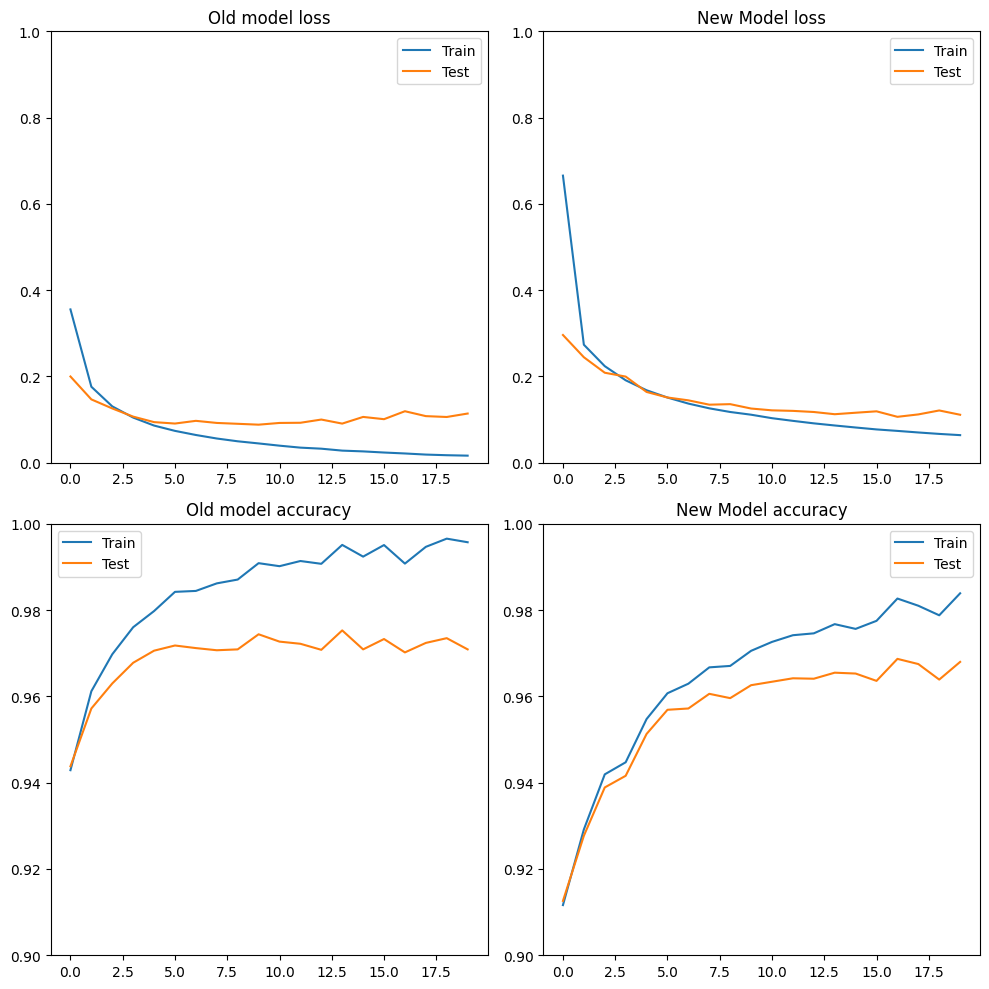

In [264]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes = axes.flatten()

axes[0].plot(train_old_losses, label="Train")
axes[0].plot(test_old_losses, label="Test")
axes[0].set_title("Old model loss")
axes[0].legend()

axes[1].plot(train_new_losses, label="Train")
axes[1].plot(test_new_losses, label="Test")
axes[1].set_title("New Model loss")
axes[1].legend()

axes[2].plot(train_old_accs, label="Train")
axes[2].plot(test_old_accs, label="Test")
axes[2].set_title("Old model accuracy")
axes[2].legend()

axes[3].plot(train_new_accs, label="Train")
axes[3].plot(test_new_accs, label="Test")
axes[3].set_title("New Model accuracy")
axes[3].legend()

axes[0].set_ylim(0, 1)
axes[1].set_ylim(0, 1)

axes[2].set_ylim(0.9, 1)
axes[3].set_ylim(0.9, 1)

plt.tight_layout()
plt.show()